In [53]:
import streamlit as st
import os
from io import StringIO
import sys
from langchain.tools import DuckDuckGoSearchRun
from langchain import hub
from langchain.agents import create_openai_functions_agent
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_agent_executor
from langchain_core.pydantic_v1 import BaseModel
from langchain.chains.openai_functions import create_structured_output_runnable
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import Field
from typing import Annotated, Any, Dict, Optional, Sequence, TypedDict, List, Tuple
from dotenv import load_dotenv, dotenv_values
import operator
from langchain.tools import BaseTool, StructuredTool, Tool
from langchain_experimental.tools import PythonREPLTool
from langchain_core.tools import tool
import random
import tabulate
import pandas as pd
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain_experimental.agents.agent_toolkits import create_csv_agent
from langchain.agents.agent_types import AgentType
from langgraph.prebuilt.tool_executor import ToolExecutor
from langchain.tools.render import format_tool_to_openai_function
from langchain_core.messages import BaseMessage
from langchain_core.agents import AgentFinish
from langgraph.prebuilt import ToolInvocation
import json
from langchain_core.messages import FunctionMessage
from langgraph.graph import StateGraph, END

load_dotenv()

True

In [54]:
openai_api_key = os.getenv("OPENAI_API_KEY")
langchain_api_key = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = 'true'
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = langchain_api_key
os.environ["LANGCHAIN_PROJECT"] ="multi-agent"
os.environ['OPENAI_API_KEY'] = openai_api_key

In [64]:
model = ChatOpenAI(temperature=0, 
                          max_tokens=1024,
    model_name="gpt-4")

## Create Tools

In [65]:
file_path= 'data.csv'

csv_agent= create_csv_agent(
        ChatOpenAI(temperature=0, model="gpt-4"),
        file_path, 
        verbose=True,
        stop=["\nObservation:"],
        agent_type=AgentType.OPENAI_FUNCTIONS,
        handle_parsing_errors=True
    )

c:\SmartCart_MBA\streamlit_app\venv\lib\site-packages\langchain_experimental\agents\agent_toolkits\pandas\base.py:242: UserWarning: Received additional kwargs {'stop': ['\nObservation:'], 'handle_parsing_errors': True} which are no longer supported.
  warnings.warn(


In [66]:
@tool("insights", return_direct=False)
def get_actionable_insights(input: str):
    """Return actionable business insights from the dataset either for a country or the whole dataset"""
    question = f"Give me actionable business insights for {input}"
    prompt = """
        Given a specific country or the entire dataset, generate actionable business insights, including but not limited to overall revenue, top-selling product, customer with the highest number of purchases, and the most popular product in the current period.
    """
    insights = csv_agent.run(prompt)
    return insights
    
@tool('chart_pdf', return_direct=False)
def get_charts_pdf(input: str):
    """Returns python executable code that first loads data.csv and generates a pdf with charts"""
    question = f"Give me a detailed report for {input}"

    prompt = """ Generate Python code that creates a comprehensive series of graphs to analyze business data for country. Also include the code for loading the data (data.csv)
    The visualization should potentially include, but not be limited to, a bar plot of the top-selling products, a line plot showing sales trends over time, and a pie chart detailing the sales distribution among top customers. 
    Additionally, consider including other relevant analyses such as sales by category, regional sales distribution, and seasonality effects on sales, if the data permits. 

    The graphs should be stored in a PDF named 'sales_report.pdf'. Utilize pandas for data handling, matplotlib for plotting, and the matplotlib.backends.backend_pdf module for generating the PDF file. 
    The code should be well-commented to explain the purpose of each graph and how it contributes to understanding the business climate in `country_name`. Include brief insights or interpretations for each plot to highlight the key takeaways and business implications derived from the data analysis.
    """  + question
    charts = csv_agent.run(prompt)
    charts = charts.split("python")[1].split('```')[0]
    exec(charts)
    return charts

tools = [get_actionable_insights, get_charts_pdf]

In [67]:
tool_executor = ToolExecutor(tools)

In [68]:
functions = [format_tool_to_openai_function(t) for t in tools]
model = model.bind_functions(functions)

In [69]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [70]:
# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state['messages']
    last_message = messages[-1]
    # If there is no function call, then we finish
    if "function_call" not in last_message.additional_kwargs:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"

# Define the function that calls the model
def call_model(state):
    messages = state['messages']
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

# Define the function to execute tools
def call_tool(state):
    messages = state['messages']
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation from the function_call
    action = ToolInvocation(
        tool=last_message.additional_kwargs["function_call"]["name"],
        tool_input=json.loads(last_message.additional_kwargs["function_call"]["arguments"]),
    )
    print(f"The agent action is {action}")
    # We call the tool_executor and get back a response
    response = tool_executor.invoke(action)
    print(f"The tool result is: {response}")
    # We use the response to create a FunctionMessage
    function_message = FunctionMessage(content=str(response), name=action.tool)
    # We return a list, because this will get added to the existing list
    return {"messages": [function_message]}

# Graph Design

In [71]:
workflow = StateGraph(AgentState)

workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)

workflow.set_entry_point("agent")

workflow.add_conditional_edges(
    "agent",
    
    should_continue,
    
    {
        "continue": "action",
        "end": END
    }
)

workflow.add_edge('action', 'agent')

app = workflow.compile()

In [73]:
from langchain_core.messages import HumanMessage, SystemMessage
# inputs = {"input": "give me a random number and then write in words and make it lower case", "chat_history": []}

system_message = SystemMessage(content="you are a helpful assistant")
user_01 = HumanMessage(content="Give insights for france")

inputs = {"messages": [system_message,user_01]}

result = app.invoke(inputs)

The agent action is tool='insights' tool_input={'input': 'france'}


> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "df['Revenue'] = df['Price'] * df['Quantity']"}`
responded: Sure, let's start by calculating the overall revenue. We can do this by multiplying the `Price` by the `Quantity` for each transaction and then summing up the results.

Let's create a new column `Revenue` in the dataframe.


Invoking: `python_repl_ast` with `{'query': "total_revenue = df['Revenue'].sum()\ntotal_revenue"}`
responded: Now, let's calculate the overall revenue.

60280024.26000001
Invoking: `python_repl_ast` with `{'query': "top_selling_product = df.groupby('ProductName')['Quantity'].sum().idxmax()\ntop_selling_product"}`
responded: The total revenue from all transactions is approximately $60,280,024.26.

Next, let's find the top-selling product. We can do this by grouping the data by `ProductName` and summing the `Quantity` for each product. The product with the hi

In [81]:
result['messages'][-1].content

[SystemMessage(content='you are a helpful assistant'),
 HumanMessage(content='Give insights for france'),
 AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{\n  "input": "france"\n}', 'name': 'insights'}}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 109, 'total_tokens': 125}, 'model_name': 'gpt-4', 'system_fingerprint': None, 'finish_reason': 'function_call', 'logprobs': None}),
 FunctionMessage(content='The most popular product on \'12/9/2019\' is the "Small Folding Scissor(Pointed Edge)".\n\nTo summarize:\n\n- The total revenue from all transactions is approximately $60,280,024.26.\n- The top-selling product is the "Popcorn Holder".\n- The customer with the highest number of purchases is the one with the customer number 14646.\n- The most popular product on \'12/9/2019\' is the "Small Folding Scissor(Pointed Edge)".', name='insights'),
 AIMessage(content='Here are some insights for France:\n\n- The total revenue from all transa

In [83]:
print(result['messages'][-1].content)

Here are some insights for France:

- The total revenue from all transactions is approximately $60,280,024.26.
- The top-selling product is the "Popcorn Holder".
- The customer with the highest number of purchases is the one with the customer number 14646.
- The most popular product on '12/9/2019' is the "Small Folding Scissor(Pointed Edge)".


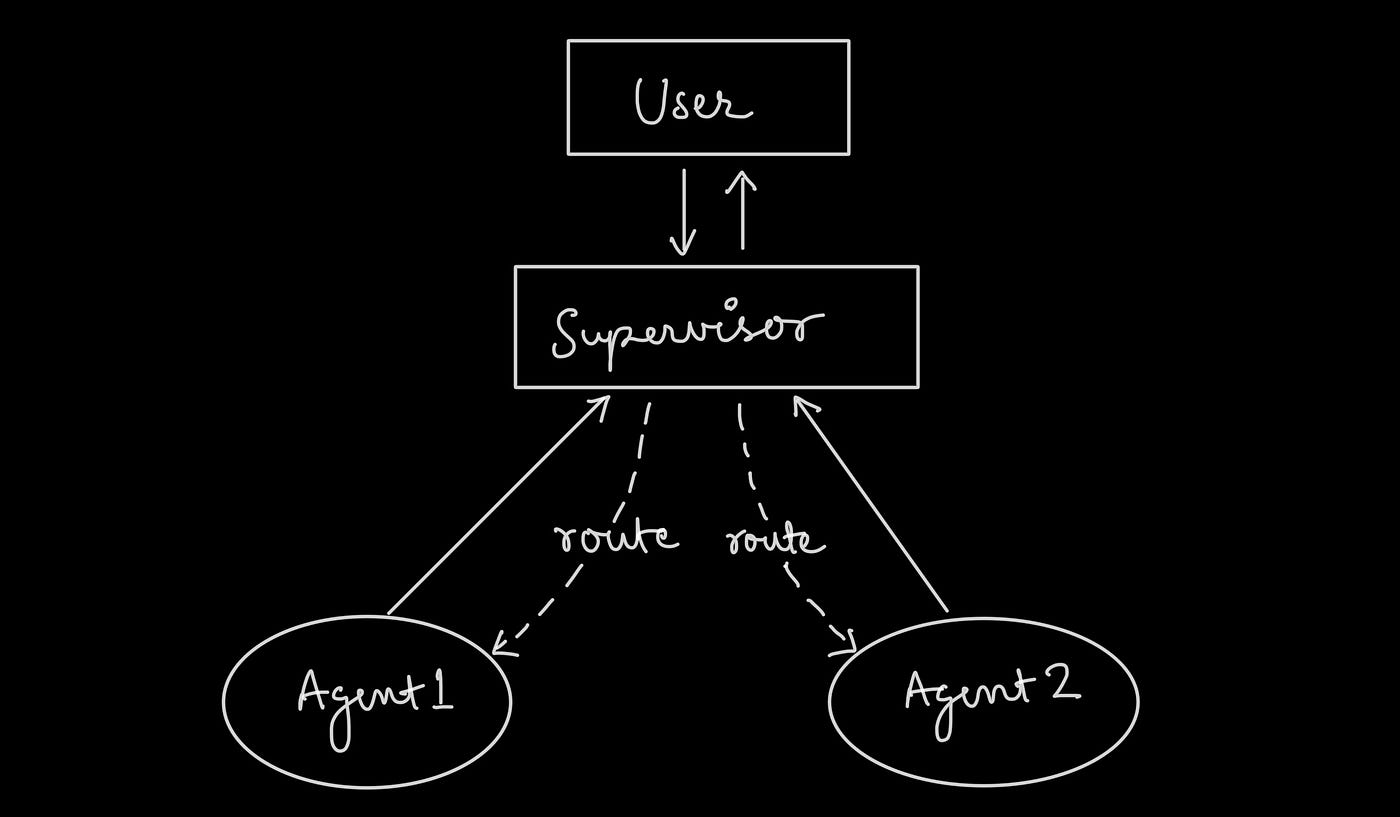

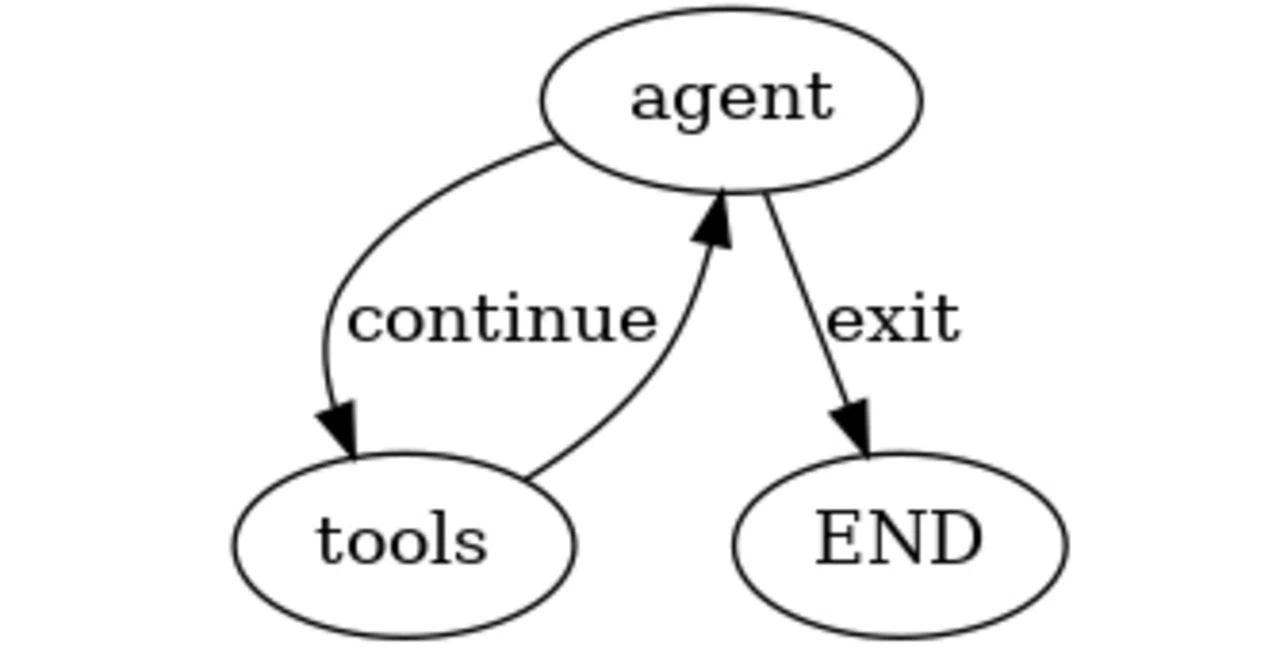